In [15]:
# Import Tensorflow for the bidirectional LSTM 
import tensorflow as tf
#from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, TimeDistributed, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt 
import numpy as np 

%matplotlib inline 
plt.style.use('ggplot')

# Readers for the conll format  
from nltk.corpus.reader import *
from nltk import flatten 

# Read the dataset 
train = ConllCorpusReader('../../Datasets/re3d-defense/CONLL-format/data/train/',
                          're3d-train.conll',
                          ['words', 'pos', 'chunk'])

test = ConllCorpusReader('../../Datasets/re3d-defense/CONLL-format/data/test/', 
                         're3d-test.conll',
                          ['words', 'pos', 'chunk'])



In [16]:
sentences = train.tagged_sents()
test_sentences = test.tagged_sents() 

print("Number of training records: " + str(len(sentences)))
print("Number of testing records: " + str(len(test.tagged_sents())))
print(sentences[1])

Number of training records: 765
Number of testing records: 200
[('The', 'B-Location'), ('hospital', 'I-Location'), ('has', 'O'), ('facilities', 'O'), ('for', 'O'), ('MRI', 'O'), ('and', 'O'), ('CT', 'O'), ('scan', 'O'), (',', 'O'), ('a', 'O'), ('gamma', 'O'), ('camera', 'O'), ('and', 'O'), ('lithotripsy', 'O'), ('device', 'O'), ('.', 'O')]


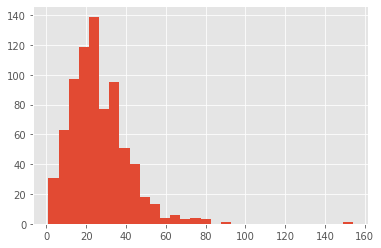

In [17]:
plt.hist([len(s) for s in sentences], bins=30)
plt.show()

In [18]:
# Max sequence is 160.
MAX_LENGTH = 160 

words = list(set(train.words()))
words.append("ENDPAD")
N_WORDS = len(words) 


tags = flatten([[tpl[1] for tpl in rec] for rec in sentences])
N_TAGS = len(tags)

word_index = { w: i for i,w in enumerate(words) }
tag_index  = { t: i for i,t in enumerate(tags)  }

X =[ [word_index[word[0]] for word in sentence] for sentence in sentences]

X_TRAIN = pad_sequences(maxlen=MAX_LENGTH, 
                        sequences=X,
                        padding="post", value=N_WORDS-1)

Y =[[tag_index[word[1]] for word in sentence] for sentence in sentences]


Y_TRAIN = pad_sequences(maxlen=MAX_LENGTH, 
                        sequences=Y,
                        padding="post", value=tag_index['O'])

Y_TRAIN = [to_categorical(i, num_classes=N_TAGS) for i in Y_TRAIN]

# print(len(X_TRAIN))
# print(len(Y_TRAIN))
# print(Y_TRAIN)
# X_TRAIN = [[tpl[0] for tpl in rec] for rec in sentences]
# Y_TRAIN = [[tpl[1] for tpl in rec] for rec in sentences]

# X_TEST = [[tpl[0] for tpl in rec] for rec in test_sentences]
# Y_TEST = [[tpl[1] for tpl in rec] for rec in test_sentences]


In [21]:
# model = Sequential() 

# model.add(LSTM(128, input_shape=(x_train.shape[1:]), activation='relu', return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(128, activation='relu'))
# model.add(Dropout(0.1))

# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(10, activation='softmax'))

# opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# model.compile(
#     loss='sparse_categorical_crossentropy', 
#     optimizer = opt,
#     metrics = ['accuracy']
# )

# model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))
# model.save('MNIST_LSTM.model')

input = Input(shape=(MAX_LENGTH,))
model = Embedding(input_dim=N_WORDS, output_dim=MAX_LENGTH, input_length=MAX_LENGTH)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.1))(model)
out   = TimeDistributed(Dense(N_TAGS, activation='softmax'))(model)

model = Model(input, out)
model.compile(optimizer="adam", loss="categorical_crossentropy")
model.fit(X_TRAIN, np.array(Y_TRAIN), batch_size=32, epochs=1,verbose =1)

# input = Input(shape=(140,))
# model = Embedding(input_dim=n_words, output_dim=140, input_length=140)(input)
# model = Dropout(0.1)(model)
# model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
# out = TimeDistributed(Dense(N_TAGS, activation="softmax"))(model)  # softmax output layer

# model = Model(input, out)

# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=1, validation_split=0.2, verbose=1)

MemoryError: Unable to allocate array with shape (765, 160, 20030) and data type float32